#  🤗 Transformers

__Автор задач: Блохин Н.В. (NVBlokhin@fa.ru)__

Материалы:
* https://huggingface.co/docs/transformers/index
* https://huggingface.co/docs/transformers/main_classes/pipelines#transformers.pipeline.task
* https://huggingface.co/docs/transformers/preprocessing
* https://huggingface.co/blog/getting-started-with-embeddings
* https://huggingface.co/sentence-transformers
* https://habr.com/ru/articles/704592/

## Задачи для совместного разбора

1\. Обсудите основные возможности и экосистему пакета 🤗 Transformers на примере задачи поиска ответа на вопрос в тексте.

In [ ]:
text = """The seminars on Deep Learning and Natural Language Processing were truly captivating,
providing a deep dive into the intricacies of these disciplines.
The wealth of knowledge and insights gained during the sessions was commendable.
However, it's disheartening to note the scarcity of homework assignments.
Anastasia, in particular, is quite concerned that the limited number of assignments might
fall short of even reaching 30. While the seminars were intellectually stimulating,
the desire for more hands-on practice through assignments remains strong,
as it is crucial for reinforcing the theoretical understanding acquired during the classes."""

In [ ]:
question1 = "What would be the ideal number of homework assignments for Anastasia"
question2 = "What are the shortcomings of the course?"

In [ ]:
import transformers

In [ ]:
from transformers import pipeline

question_answerer = pipeline(
    "question-answering",
    model='distilbert-base-uncased-distilled-squad'
)

result = question_answerer(
    question=question2,
    context=text
)

In [ ]:
result

{'score': 0.2378229945898056,
 'start': 275,
 'end': 307,
 'answer': 'scarcity of homework assignments'}

In [ ]:
from transformers import DistilBertTokenizer, DistilBertForQuestionAnswering
import torch

tokenizer = DistilBertTokenizer.from_pretrained(
    'distilbert-base-uncased-distilled-squad'
)

model = DistilBertForQuestionAnswering.from_pretrained(
    'distilbert-base-uncased-distilled-squad'
)

question = question1

inputs = tokenizer(question, text, return_tensors="pt")
inputs

{'input_ids': tensor([[  101,  2054,  2052,  2022,  1996,  7812,  2193,  1997, 19453, 14799,
          2005, 19447,   102,  1996, 17239,  2006,  2784,  4083,  1998,  3019,
          2653,  6364,  2020,  5621, 14408, 17441,  1010,  4346,  1037,  2784,
         11529,  2046,  1996, 20014, 14735,  9243,  1997,  2122, 12736,  1012,
          1996,  7177,  1997,  3716,  1998, 20062,  4227,  2076,  1996,  6521,
          2001,  4012,  3549, 20782,  1012,  2174,  1010,  2009,  1005,  1055,
          9841, 14644,  6528,  2075,  2000,  3602,  1996, 11228, 12972,  1997,
         19453, 14799,  1012, 19447,  1010,  1999,  3327,  1010,  2003,  3243,
          4986,  2008,  1996,  3132,  2193,  1997, 14799,  2453,  2991,  2460,
          1997,  2130,  4285,  2382,  1012,  2096,  1996, 17239,  2020,  7789,
          2135, 27295,  1010,  1996,  4792,  2005,  2062,  2398,  1011,  2006,
          3218,  2083, 14799,  3464,  2844,  1010,  2004,  2009,  2003, 10232,
          2005, 27788, 29278,  6129,  

In [ ]:
with torch.no_grad():
    outputs = model(**inputs)

In [ ]:
outputs

In [ ]:
answer_start_index = torch.argmax(outputs.start_logits)
answer_end_index = torch.argmax(outputs.end_logits)

predict_answer_tokens = inputs.input_ids[0, answer_start_index : answer_end_index + 1]
tokenizer.decode(predict_answer_tokens)

'30'

## Задачи для самостоятельного решения

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [152]:
import transformers
from transformers import pipeline
import json
import pandas as pd
import nltk
import torch
from nltk.translate.bleu_score import corpus_bleu
from torchtext.data.metrics import bleu_score
from sklearn.metrics import f1_score
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [ ]:
!pip install sentence-transformers

from sentence_transformers import SentenceTransformer
from sklearn.decomposition import PCA

<p class="task" id="1"></p>

### 1
Среди предобученных моделей найдите модель для перевода текста с русского языка на английский. Протестируйте данную модель на нескольких предложениях, используя `transformers.pipeline`. Выведите результаты работы в следующем виде:

```
sentence1_ru -> sentence1_en
sentence2_ru -> sentence2_en
```

Получите перевод для всех текстов из файла `RuBQ_2.0_test.json` и посчитайте BLEU-score.

- [x] Проверено на семинаре

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

### facebook/nllb-200-distilled-600M

In [ ]:
with open('/content/drive/MyDrive/data/RuBQ_2.0_test.json', 'r', encoding='utf-8') as file:
    data = json.load(file)

data_test = pd.DataFrame(data)
data_test = data_test[['question_text', 'question_eng']]
data_test['question_text'] = data_test['question_text'].apply(lambda x: x.lower())
data_test['question_eng'] = data_test['question_eng'].apply(lambda x: x.lower())
ru = data_test['question_text'].tolist()
en_true = data_test['question_eng'].tolist()

In [ ]:
translator = pipeline("translation", model='facebook/nllb-200-distilled-600M', device=device)

In [ ]:
en_pred_bleu = []
for x in ru:
    en = translator(x, src_lang='ru', tgt_lang='en')
    en_pred_bleu.append(en[0]['translation_text'].split())

en_true_bleu = [[x.split()] for x in en_true]

print(f"BLEU Score: {bleu_score(en_pred_bleu, en_true_bleu)}") # очень плохо

BLEU Score: 0.05992025509476662


### facebook/wmt19-ru-en

In [ ]:
%%capture
!pip install sacremoses

In [32]:
with open('/content/drive/MyDrive/data/RuBQ_2.0_test.json', 'r', encoding='utf-8') as file:
    data = json.load(file)

data_test = pd.DataFrame(data)
data_test = data_test[['question_text', 'question_eng']]
data_test['question_text'] = data_test['question_text'].apply(lambda x: x.lower())
data_test['question_eng'] = data_test['question_eng'].apply(lambda x: x.lower())
ru = data_test['question_text'].tolist()
en_true = data_test['question_eng'].tolist()
ru[:2], en_true[:2]

(['какой стране принадлежит знаменитый остров пасхи?',
  'с какой музыкальной группой неразрывно связано имя мика джаггера?'],
 ['which country does the famous easter island belong to?',
  "which music group is mick jagger's name inextricably linked to?"])

In [ ]:
translator = pipeline("translation", model='facebook/wmt19-ru-en', device=device)

In [33]:
en_preds = []
for i, x in enumerate(ru):
    en_pred = translator(x)[0]['translation_text']
    en_preds.append(en_pred)
    if i < 9:
        print(f'{x}      ->      {en_pred}')

какой стране принадлежит знаменитый остров пасхи?      ->      which country owns the famous Easter Island?
с какой музыкальной группой неразрывно связано имя мика джаггера?      ->      Which band has Mick Jagger's name inextricably linked to?
где находится летний сад?      ->      Where is the summer garden?
какой город является столицей туркмении?      ->      which city is the capital of Turkmenistan?
в каком городе издавалась с 1857 г. а. герценом и н. огаревым первая российская революционная газета "колокол"?      ->      in which city was the first Russian revolutionary newspaper, Kolokol, published since 1857 by A. Herzen and A. Ogarev?
в какой стране находится второй из самых высоких действующих вулканов с забавным названием попокатепетль (5452 м)?      ->      Which country is home to the second highest active volcano with the amusing name Popocatepetl (5,452 m)?
в каком виде спорта прославилась курникова?      ->      in which sport did Kurnikova become famous?
в каком город

In [31]:
en_preds_bleu = [x.split() for x in en_preds]
en_true_bleu = [[x.split()] for x in en_true]
print(f"BLEU Score: {bleu_score(en_preds_bleu, en_true_bleu)}")

BLEU Score: 0.34151589290666945


<p class="task" id="2"></p>

### 2
Загрузите данные из файла `reviews_polarity.csv`. Среди предобученных моделей найдите модель для классификации тональности русскоязычного текста (позитивный/негативный или позитивный/негативный/нейтральный). Протестируйте данную модель на нескольких предложениях, используя `transformers.pipeline`. Выведите результаты работы в следующем виде:

```
sentence1 -> class1
sentence2 -> class2
...
```

Получите прогноз для всех текстов из файла и посчитайте F1-score. Для ускорения работы модели вы можете перенести ее на GPU и использовать возможности pipeline для работы с батчами и генераторами.

- [ ] Проверено на семинаре

In [150]:
data = pd.read_csv('/content/drive/MyDrive/data/reviews_polarity.csv')
data.head()

,text,class
0,"Очень хорошо что открылась 5 ка, теперь не над...",1
1,"Тесно, вечная сутолока, между рядами трудно ра...",0
2,Магазин в пешей доступности. После ремонта и р...,1
3,Магазин хороший цены и скидки нормальные токо ...,1
4,Сложно найти в торговом центре. А магазин - норм),1


In [53]:
reviews = data['text'].tolist()
true = data['class'].tolist()
reviews[:5], true[:5]

(['Очень хорошо что открылась 5 ка, теперь не надо далеко ехать все рядом!',
  'Тесно, вечная сутолока, между рядами трудно разойтись, грязно. Была пару раз. Больше не пойду. ',
  'Магазин в пешей доступности. После ремонта и реконструкции стал намного лучше и уютнее. Радует появившаяся пекарня и выпечка.',
  'Магазин хороший цены и скидки нормальные токо все время у вас работает одна касса тк не у всех есть деньги на картах всегда',
  'Сложно найти в торговом центре. А магазин - норм)'],
 [1, 0, 1, 1, 1])

In [44]:
classificator = pipeline("text-classification", model="MaxKazak/ruBert-base-russian-emotion-detection", device=device)

config.json:   0%|          | 0.00/1.25k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/713M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/378 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.78M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.71M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [79]:
preds = []
for i, x in enumerate(reviews):
    pred = classificator(x)[0]['label']
    preds.append(pred)
    if i < 9:
        print(f'{x}      ->      {pred}')

Очень хорошо что открылась 5 ка, теперь не надо далеко ехать все рядом!      ->      joy
Тесно, вечная сутолока, между рядами трудно разойтись, грязно. Была пару раз. Больше не пойду.       ->      disgust
Магазин в пешей доступности. После ремонта и реконструкции стал намного лучше и уютнее. Радует появившаяся пекарня и выпечка.      ->      joy
Магазин хороший цены и скидки нормальные токо все время у вас работает одна касса тк не у всех есть деньги на картах всегда      ->      neutral
Сложно найти в торговом центре. А магазин - норм)      ->      neutral
После ремонта магазин в нутри стал ещё лучше. Больше ассортимент товаров, плюс скидки на продукцию. Вежливый персонал. Есть небольшая парковка.      ->      neutral
Все свежее, продукты.      ->      neutral
Наша любимая 🤩 
Сделали перестановку, выпечку добавили, кофе с собой можно организовать! Улучшение всегда хорошо! 👌🏻      ->      joy
Большой выбор продуктов, разнообразные акции      ->      neutral


In [80]:
set(preds)

{'anger',
 'disgust',
 'fear',
 'guilt',
 'interest',
 'joy',
 'neutral',
 'sadness',
 'surpise'}

In [81]:
def replace_value(value):
    if value in ['joy', 'neutral', 'interest', 'surpise']:
        return 1
    elif value in ['disgust', 'anger', 'fear', 'sadness', 'guilt']:
        return 0

preds_binary = list(map(replace_value, preds))

In [82]:
set(preds_binary)

{0, 1}

In [86]:
f1_score(true, preds_binary)

0.8960480964447033

<p class="task" id="3"></p>

### 3
Создайте токенизатор, соответствующий модели из предыдущего задания, используя класс `AutoTokenizer`. Возьмите одно предложение из набора данных и токенизируйте его, используя созданный объект. Выведите на экран полученный результат. Выполните обратное преобразование: получите текст по набору токенов и выведите результат на экран.

Получите батч из 10 предложений и токенизируйте его. Продемонстрируйте возможности токенизатора для паддинга, обрезки, преобразования в тензоры.

- [ ] Проверено на семинаре

In [88]:
tokenizer = AutoTokenizer.from_pretrained("MaxKazak/ruBert-base-russian-emotion-detection", device='cuda')

In [122]:
example = reviews[7777]
example

'Какой-то грязный магазин. И не понятно что и где находится.'

In [95]:
example_tokenized = tokenizer(example)
example_tokenized

{'input_ids': [101, 94681, 378, 133, 696, 8179, 667, 378, 10001, 126, 107, 672, 5943, 693, 107, 1153, 2620, 126, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [96]:
example_decoded = tokenizer.decode(example_tokenized['input_ids'])
example_decoded

'[CLS] какои - то грязныи магазин. и не понятно что и где находится. [SEP]'

In [103]:
batch = reviews[7777:7787]
batch

['Какой-то грязный магазин. И не понятно что и где находится.',
 'Часто сюда ездим.\nНедалеко дача.\nВсе устраивает.\nИ даже есть банкомат Сбербанк.',
 'Мне понравился сервис в этой Пятерочке. Заходила с ребёнком и получила удовольствие от обслуживания. \nВ магазине чисто, товар выставлен аккуратно.',
 'Ассортимент по сети магазинов отличается. ',
 'Круглосуточно работает',
 'Все без масок. Даже на кассе не просят надеть. Хоть это делайте. Была ужасная жара, мне стало плохо и я зашла за водой Она на втором этаже!!!!! ',
 'Очень любезные продавцы! Товары хорошего качества!',
 'Хороший магазин.',
 'Маленькая пятерочка, без касс самообслуживания.',
 'Соответствует своей концепции магазина у дома.']

In [116]:
batch_tokenized = tokenizer(batch)

for i in batch_tokenized['input_ids']:
    print(len(i))

19
20
28
8
4
40
11
6
11
10


In [117]:
batch_tokenized = tokenizer(batch, padding=True, truncation=True, max_length=20, return_tensors="pt")

for i in batch_tokenized['input_ids']:
    print(len(i))

20
20
20
20
20
20
20
20
20
20


In [118]:
batch_tokenized['input_ids']

tensor([[  101, 94681,   378,   133,   696,  8179,   667,   378, 10001,   126,
           107,   672,  5943,   693,   107,  1153,  2620,   126,   102,     0],
        [  101,  2828,  4024,  5993,  4728,   126,  9921, 57357,   126,   780,
         17266,   126,   107,  1180,  1114, 95867, 83492,  9635,   126,   102],
        [  101,  1098, 20132, 19071,   113,   736,   378, 23654,  4107,   126,
         66155,   110, 15483,   107,  5406, 11684,   700, 17106,   126,   102],
        [  101, 50369,   654,  5273, 15339, 10584,   126,   102,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0],
        [  101, 45293,  4209,   102,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0],
        [  101,   780,  1151, 74621,   126,  1180,   660, 54650,   672, 17869,
         27854,   126,  3197,   736,  1196, 42699,   126,  1073, 47297,   102],
        [  101,  1179, 65882,   376, 53718,   

<p class="task" id="4"></p>

### 4
Решите задачу 2, создав объект токенизатора (`AutoTokenizer`) и модель (`AutoModelForSequenceClassification`).

- [ ] Проверено на семинаре

In [120]:
# объект токенизатора
tokenizer = AutoTokenizer.from_pretrained("MaxKazak/ruBert-base-russian-emotion-detection")
# модель
classificator = AutoModelForSequenceClassification.from_pretrained("MaxKazak/ruBert-base-russian-emotion-detection")

In [128]:
classificator = pipeline("text-classification", model=classificator, tokenizer=tokenizer, device=device)

In [129]:
preds = []
for i, x in enumerate(reviews):
    pred = classificator(x)[0]['label']
    preds.append(pred)
    if i < 9:
        print(f'{x}      ->      {pred}')

Очень хорошо что открылась 5 ка, теперь не надо далеко ехать все рядом!      ->      joy
Тесно, вечная сутолока, между рядами трудно разойтись, грязно. Была пару раз. Больше не пойду.       ->      disgust
Магазин в пешей доступности. После ремонта и реконструкции стал намного лучше и уютнее. Радует появившаяся пекарня и выпечка.      ->      joy
Магазин хороший цены и скидки нормальные токо все время у вас работает одна касса тк не у всех есть деньги на картах всегда      ->      neutral
Сложно найти в торговом центре. А магазин - норм)      ->      neutral
После ремонта магазин в нутри стал ещё лучше. Больше ассортимент товаров, плюс скидки на продукцию. Вежливый персонал. Есть небольшая парковка.      ->      neutral
Все свежее, продукты.      ->      neutral
Наша любимая 🤩 
Сделали перестановку, выпечку добавили, кофе с собой можно организовать! Улучшение всегда хорошо! 👌🏻      ->      joy
Большой выбор продуктов, разнообразные акции      ->      neutral


In [131]:
def replace_value(value):
    if value in ['joy', 'neutral', 'interest', 'surpise']:
        return 1
    elif value in ['disgust', 'anger', 'fear', 'sadness', 'guilt']:
        return 0

preds_binary = list(map(replace_value, preds))

In [132]:
f1_score(true, preds_binary)

0.8960480964447033

<p class="task" id="5"></p>

### 5
Используя пакет `sentence-transformers`, загрузите модель `distiluse-base-multilingual-cased-v1`. Используя эту модель, получите эмбеддинги всех предложений из набора данных. Во время генерации эмбеддингов используйте батчи размера 64 и отобразите процесс получения эмбеддингов в виде полосы загрузки.

Уменьшите размерность эмбеддингов при помощи PCA и отобразите точки в двумерном пространстве, раскрасив их в цвет соответствующего им класса.

- [ ] Проверено на семинаре

In [137]:
model = SentenceTransformer('distiluse-base-multilingual-cased-v1', device=device)

In [139]:
embeddings = []

num_sentences = len(reviews)

for start_idx in tqdm(range(0, num_sentences, 64)):
    end_idx = min(start_idx + 64, num_sentences)
    batch_sentences = reviews[start_idx:end_idx]
    embeddings.extend(model.encode(batch_sentences))

100%|██████████| 598/598 [00:51<00:00, 11.68it/s]


In [142]:
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings)

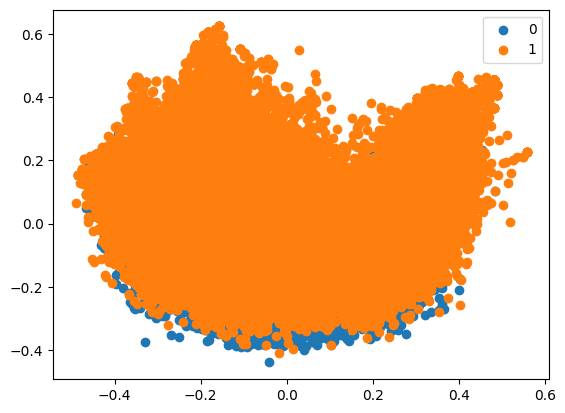

In [155]:
unique_labels = np.unique(data['class'].tolist())
label_color_map = {label: plt.cm.tab10(i) for i, label in enumerate(unique_labels)}

for label, color in label_color_map.items():
    indices = np.where(data['class'].tolist() == label)[0]
    plt.scatter(reduced_embeddings[indices, 0], reduced_embeddings[indices, 1], c=[color], label=f'{label}')

plt.legend()
plt.show()

## Обратная связь
- [ ] Хочу получить обратную связь по решению